### Import required libraries

In [1]:

import pymysql
from cryptography.fernet import Fernet
import json
from collections import namedtuple
import time
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy import create_engine 
from sklearn import model_selection
from sklearn.metrics import classification_report as cr
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from yellowbrick.classifier import ClassificationReport
from yellowbrick.features import FeatureImportances
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import ROCAUC

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing.data import QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

from ipywidgets import interact

from imblearn.over_sampling import SMOTE 
from collections import Counter

%matplotlib inline

### Increase the size of the screen

In [2]:
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Decrypt Credentials and Connect to Database

In [3]:
#Uncode the secret license file
def unencrypt():
    try:
        key = b'IXx5rHfP15FqP4ahx2pwcud-XmcBzU553Ri6p-nVhnc=' #Fernet.generate_key()
        cipher_suite = Fernet(key)
        with open('/usr/local/etc/musicmood_bytes.bin', 'rb') as file_object:
            for line in file_object:
                encryptedpwd = line
        uncipher_text = (cipher_suite.decrypt(encryptedpwd))
        plain_text_encryptedpassword = bytes(uncipher_text).decode("utf-8") #convert to string
        x = json.loads(plain_text_encryptedpassword, object_hook=lambda d: namedtuple('X', d.keys())(*d.values()))
        return x
    except Exception as e:
        print(str(e))
        return "Error" 

#Setup the database connection
credentials = unencrypt()
user_id = credentials.user
user_password = credentials.password
dbname = credentials.dbname
server = credentials.server
conn = pymysql.connect(server,user_id,user_password,dbname)

### Load the clean dataset

In [4]:
start_time = time.time()
df = pd.read_sql('SELECT * FROM songs_instances_data', con = conn)
print('--- %s seconds ---' % (time.time() - start_time))
    
df.drop(['index'],axis=1, inplace=True)
df.head(15)

df.describe()
#print(df.columns)

--- 0.9828429222106934 seconds ---


,duration,loudness,mode,tempo,time_signature,speed_general,artist_familiarity,artist_hotttnesss,words_song_u,words_song,words_song_r,words_genre_u,words_genre,words_genre_r,words_second,gnr_Blues,gnr_Country,gnr_Folk,gnr_Funk,gnr_House Electronic Trance,gnr_Jazz,gnr_Latin,gnr_Metal,gnr_Pop,gnr_Pop Standards,gnr_Punk,gnr_Rap Hip Hop,gnr_Rhythm and Blues,gnr_Rock,gnr_Rock and Roll,gnr_Ska Reggae Dancehall,key_0,key_1,key_2,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,is_top40
count,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.00000,12255.000000,12255.000000,12255.000000
mean,237.804162,-9.215717,0.709914,124.189140,3.626030,2.495390,0.670480,0.479963,86.935599,259.026551,0.364790,87.425214,259.429376,0.341456,1.415320,0.006691,0.067646,0.026275,0.000326,0.029621,0.022358,0.006528,0.067156,0.137087,0.019502,0.002285,0.045777,0.049857,0.368666,0.031089,0.002856,0.121746,0.081110,0.110894,0.087475,0.077193,0.058099,0.116932,0.056140,0.10967,0.068788,0.081191,0.379111
std,90.091553,3.902081,0.453820,31.397375,1.114364,0.561065,0.124608,0.116631,34.186147,124.808211,0.112119,21.491572,73.601847,0.035276,0.375069,0.081529,0.251147,0.159958,0.018064,0.169545,0.147852,0.080535,0.250303,0.343953,0.138288,0.047747,0.209010,0.217659,0.482463,0.173566,0.053367,0.327006,0.273015,0.314013,0.282541,0.266908,0.233940,0.321352,0.230202,0.31249,0.253104,0.273140,0.485185
min,2.000000,-37.695999,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.040000,67.000000,172.000000,0.260000,0.302600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,181.000000,-11.644000,0.000000,100.880500,4.000000,2.000000,0.589133,0.400982,69.000000,185.000000,0.300000,80.000000,229.000000,0.310000,1.398200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,227.000000,-8.686000,1.000000,121.603996,4.000000,3.000000,0.671095,0.463155,86.935599,259.000000,0.335624,80.000000,229.000000,0.350000,1.527000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
75%,272.000000,-6.260500,1.000000,141.956000,4.000000,3.000000,0.761731,0.540461,96.000000,296.000000,0.410000,86.000000,265.000000,0.350000,1.527000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000
max,1241.000000,-0.278000,1.000000,249.559006,7.000000,3.000000,1.000000,1.082500,480.000000,2539.000000,1.000000,178.000000,530.000000,0.420000,2.115800,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000


### Visualize only important features 

In [5]:

songs = df [['duration', 'loudness', 'mode','time_signature', \
             'words_song','words_genre', 'words_second', 'tempo', \
             'artist_hotttnesss', 'gnr_Blues', 'gnr_Country', 'gnr_Folk', 'gnr_Funk', \
             'gnr_House Electronic Trance', 'gnr_Jazz', 'gnr_Latin', 'gnr_Metal', 'gnr_Pop', 'gnr_Pop Standards', \
             'gnr_Punk', 'gnr_Rap Hip Hop', 'gnr_Rhythm and Blues', 'gnr_Rock', 'gnr_Rock and Roll', \
             'gnr_Ska Reggae Dancehall','key_0','key_1','key_2','key_4','key_5','key_6','key_7','key_8','key_9',
             'key_10','key_11','is_top40']]
songs.shape

(12255, 37)

### Addressing Class Imbalance with SMOTE

In [6]:

array = songs.values
X = array[:,0:-1]
Y = array[:,-1] #is_top40

sm = SMOTE(random_state=42)
X_resampled, Y_resampled = sm.fit_sample(X, Y)
X_resampled.shape

(15218, 36)

### Split-Out validation dataset

In [7]:
classes = ['IsTop40','NoHit']
#classes = [1,0]
validation_size = 0.2
seed = 7
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X_resampled, Y_resampled,test_size=validation_size,random_state=seed)
print(songs.shape)
print(X_train.shape)
print(X_validation.shape)


(12255, 37)
(12174, 36)
(3044, 36)


  ### Test options and evaluation metric

In [8]:
seed = 7
scoring = 'accuracy'

### Selected Algorithms

In [15]:
models = []
models.append(('RFC', RandomForestClassifier(criterion= 'gini', max_depth= 20, n_estimators= 120)))
models.append(('LGR', LogisticRegression(C= 1.15, class_weight= 'balanced', dual= False, fit_intercept= True, 
                           max_iter= 10000, multi_class= 'ovr', n_jobs= 2, random_state= 7, solver= 'sag', tol= 0.0001,
                           verbose= 0, warm_start= True)))
models.append(('ABC', AdaBoostClassifier()))


### Interactive Comparison

In [10]:
@interact(model=list(models))
def plot_matrix(model):
    fig, ((ax0,ax1),(ax2,ax3)) = plt.subplots(2,2,figsize=(12,8))
    
    pipe_mdl = make_pipeline(QuantileTransformer(),
                             model)
    pipe_mdl.fit(X_train, Y_train)
    predictions = pipe_mdl.predict(X_validation)
    
    clr = ClassificationReport(pipe_mdl, classes=classes, support=True, ax = ax0)
    clr.fit(X_train, Y_train)  # Fit the visualizer and the model
    clr.score(X_validation, Y_validation)  # Evaluate the model on the test data
    clr.finalize()


    cm = ConfusionMatrix(pipe_mdl, classes = [0,1] , ax = ax1)
    cm.fit(X_train, Y_train)
    cm.score(X_validation, Y_validation)
    cm.finalize()

    cpe = ClassPredictionError(pipe_mdl, classes=classes, ax = ax2)
    cpe.fit(X_train, Y_train)
    cpe.score(X_validation, Y_validation)
    cpe.finalize()

    rocauc = ROCAUC(pipe_mdl, classes=classes, ax = ax3)
    rocauc.fit(X_train, Y_train)
    rocauc.score(X_validation, Y_validation)
    rocauc.finalize()

    plt.show()
    


interactive(children=(Dropdown(description='model', options=(('RFC', RandomForestClassifier(bootstrap=True, cl…

### Compare the Models

No handles with labels found to put in legend.


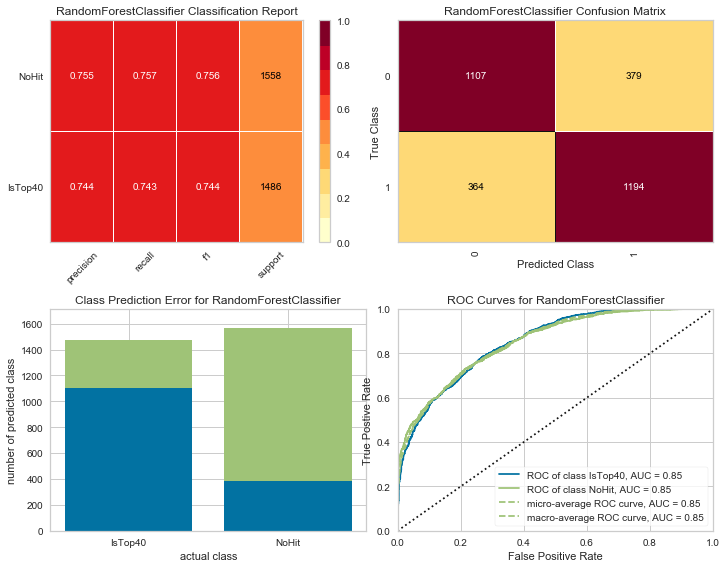

No handles with labels found to put in legend.


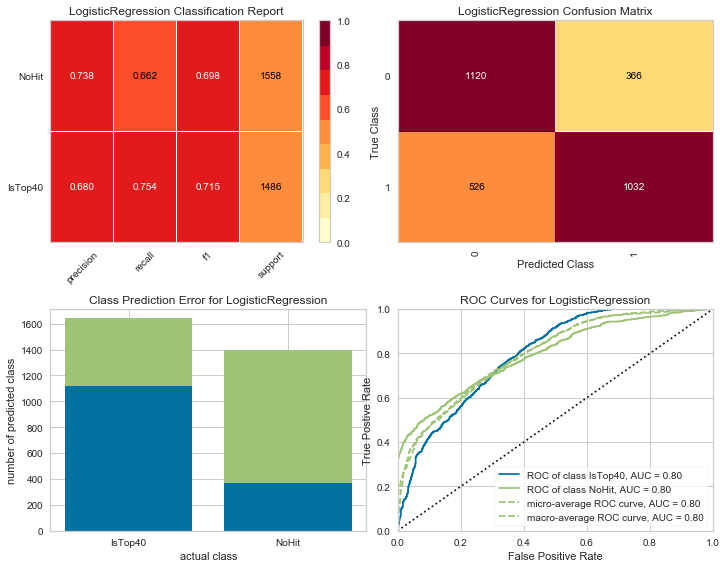

No handles with labels found to put in legend.


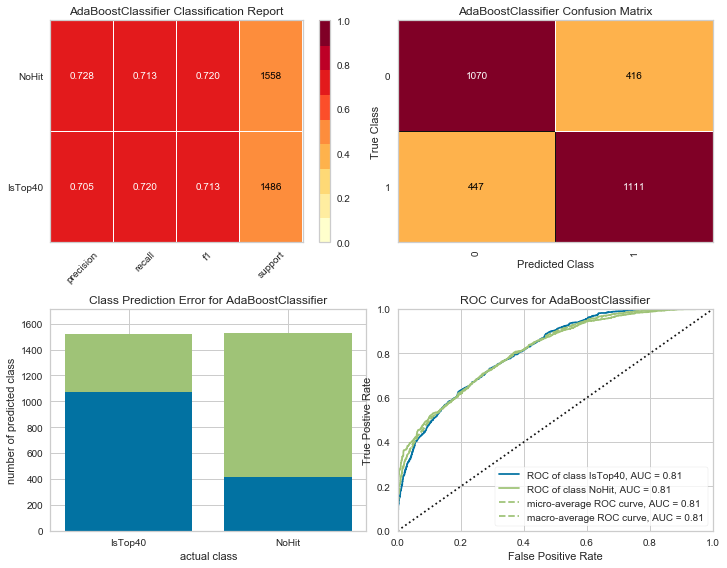

In [16]:
for name,model in models:
    plot_matrix(model)

### Same Graphic Comparison

In [19]:
graphs = []
graphs.append("Classification Report")
graphs.append("Confusion Matrix")
graphs.append("Prediction Error")
graphs.append("ROC/AUC Curve")

@interact(Graph=list(graphs))
def plot_matrix(Graph="Classification Report"):
    fig, (ax0,ax1,ax2) = plt.subplots(1,3,figsize=(16,4))
    

    pipe_mdl_RFC = make_pipeline(QuantileTransformer(),
                                 RandomForestClassifier(criterion= 'gini', max_depth= 20, n_estimators= 120))
    pipe_mdl_LGR = make_pipeline(QuantileTransformer(),
                                 LogisticRegression(C= 1.15, class_weight= 'balanced', dual= False, fit_intercept= True, 
                           max_iter= 10000, multi_class= 'ovr', n_jobs= 2, random_state= 7, solver= 'sag', tol= 0.0001,
                           verbose= 0, warm_start= True))
    pipe_mdl_ABC = make_pipeline(QuantileTransformer(),
                                 AdaBoostClassifier())
    
    pipe_mdl_RFC.fit(X_train, Y_train)
    pipe_mdl_LGR.fit(X_train, Y_train)
    pipe_mdl_ABC.fit(X_train, Y_train)
    
    #predictions = pipe_mdl.predict(X_validation)
    if Graph == "Classification Report":
        clr1 = ClassificationReport(pipe_mdl_RFC, classes=classes, support=True, ax = ax0)
        clr1.fit(X_train, Y_train)  # Fit the visualizer and the model
        clr1.score(X_validation, Y_validation)  # Evaluate the model on the test data
        clr1.finalize()
        
        clr2 = ClassificationReport(pipe_mdl_LGR, classes=classes, support=True, ax = ax1)
        clr2.fit(X_train, Y_train)  # Fit the visualizer and the model
        clr2.score(X_validation, Y_validation)  # Evaluate the model on the test data
        clr2.finalize()
        
        clr3 = ClassificationReport(pipe_mdl_ABC, classes=classes, support=True, ax = ax2)
        clr3.fit(X_train, Y_train)  # Fit the visualizer and the model
        clr3.score(X_validation, Y_validation)  # Evaluate the model on the test data
        clr3.finalize()
    elif Graph == "Confusion Matrix":
        cm1 = ConfusionMatrix(pipe_mdl_RFC, classes = [0,1] , ax = ax0)
        cm1.fit(X_train, Y_train)
        cm1.score(X_validation, Y_validation)
        cm1.finalize()
        
        cm2 = ConfusionMatrix(pipe_mdl_LGR, classes = [0,1] , ax = ax1)
        cm2.fit(X_train, Y_train)
        cm2.score(X_validation, Y_validation)
        cm2.finalize()
        
        cm3 = ConfusionMatrix(pipe_mdl_ABC, classes = [0,1] , ax = ax2)
        cm3.fit(X_train, Y_train)
        cm3.score(X_validation, Y_validation)
        cm3.finalize()
    elif Graph == "Prediction Error":
        cpe1 = ClassPredictionError(pipe_mdl_RFC, classes=classes, ax = ax0)
        cpe1.fit(X_train, Y_train)
        cpe1.score(X_validation, Y_validation)
        cpe1.finalize()
        
        cpe2 = ClassPredictionError(pipe_mdl_LGR, classes=classes, ax = ax1)
        cpe2.fit(X_train, Y_train)
        cpe2.score(X_validation, Y_validation)
        cpe2.finalize()
        
        cpe3 = ClassPredictionError(pipe_mdl_ABC, classes=classes, ax = ax2)
        cpe3.fit(X_train, Y_train)
        cpe3.score(X_validation, Y_validation)
        cpe3.finalize()
    else:
        rocauc1 = ROCAUC(pipe_mdl_RFC, classes=classes, ax = ax0)
        rocauc1.fit(X_train, Y_train)
        rocauc1.score(X_validation, Y_validation)
        rocauc1.finalize()
        
        rocauc2 = ROCAUC(pipe_mdl_LGR, classes=classes, ax = ax1)
        rocauc2.fit(X_train, Y_train)
        rocauc2.score(X_validation, Y_validation)
        rocauc2.finalize()
        
        rocauc3 = ROCAUC(pipe_mdl_ABC, classes=classes, ax = ax2)
        rocauc3.fit(X_train, Y_train)
        rocauc3.score(X_validation, Y_validation)
        rocauc3.finalize()

    plt.show()
    

interactive(children=(Dropdown(description='Graph', options=('Classification Report', 'Confusion Matrix', 'Pre…

### Compare the Models

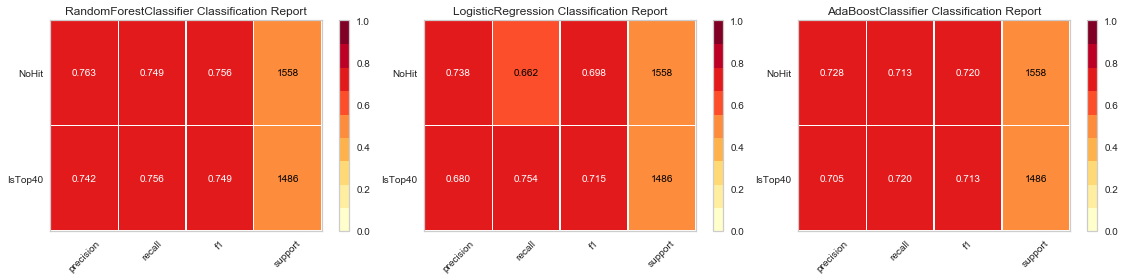

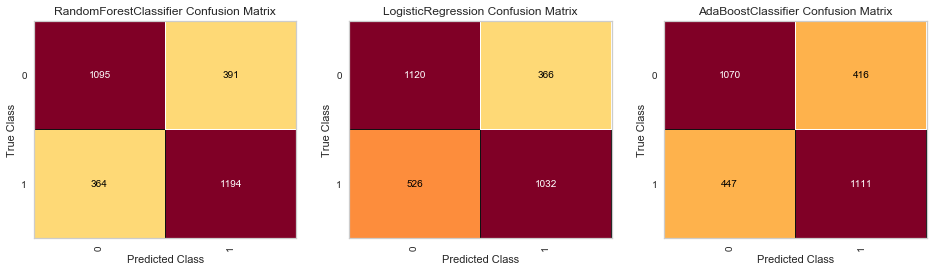

No handles with labels found to put in legend.
No handles with labels found to put in legend.


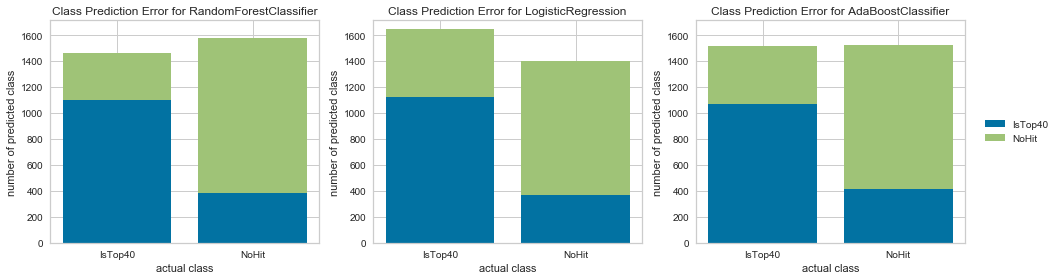

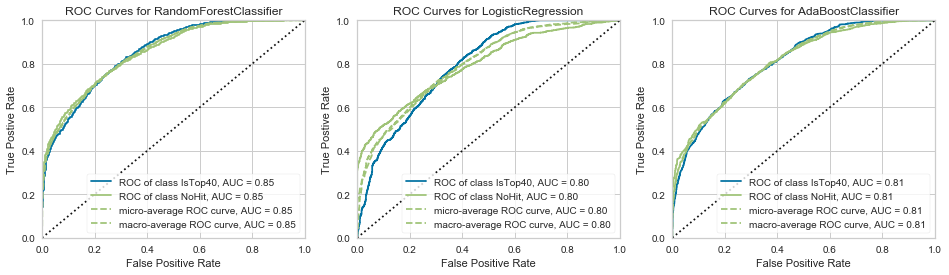

In [20]:
for pic in graphs:
    plot_matrix(pic)